# 算法
- warmup

In [ ]:
import math
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import AdamW
def get_cosine_schedule_with_warmup(optimizer: Optimizer,num_warmup_steps: int,
        num_training_steps: int,num_cycles: float = 0.5,last_epoch: int = -1):
	"""
	Create a schedule with a learning rate that decreases following the values of the cosine function between the
	initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
	initial lr set in the optimizer.

	Args:
		optimizer (:class:`~torch.optim.Optimizer`):
		The optimizer for which to schedule the learning rate.
		num_warmup_steps (:obj:`int`):
		The number of steps for the warmup phase.
		num_training_steps (:obj:`int`):
		The total number of training steps.
		num_cycles (:obj:`float`, `optional`, defaults to 0.5):
		The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
		following a half-cosine).
		last_epoch (:obj:`int`, `optional`, defaults to -1):
		The index of the last epoch when resuming training.

	Return:
		:obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
	"""
	def lr_lambda(current_step):
		# Warmup
		if current_step < num_warmup_steps:
			return float(current_step) / float(max(1, num_warmup_steps))
		# decadence
		progress = float(current_step - num_warmup_steps) / float(
			max(1, num_training_steps - num_warmup_steps)
		)
		return max(
			0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
		)

	return LambdaLR(optimizer, lr_lambda, last_epoch)

optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

optimizer.step()
scheduler.step()

# 正则化
- Layer−>BatchNorm−>Activation
- Layer−>Activation−>LayerNorm
- Layer−>Activation−>BatchNorm(可选)−>Dropout

In [ ]:
# 定义L1正则化的函数
def l1_penalty(params, lamb):
    l1_norm = sum(p.abs().sum() for p in params)
    return lamb * l1_norm

# 定义模型
model = nn.Sequential(
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

# 定义损失函数
criterion = nn.MSELoss()

# 定义优化器
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 在训练循环中添加L1正则化
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss += l1_penalty(model.parameters(), lamb=0.01)  # 0.01是L1正则化系数
    loss.backward()
    optimizer.step()

# Sofmax
- https://blog.csdn.net/qq_22841387/article/details/141328944

In [ ]:
import numpy as np
outputs =  np.array([0.2,0.7,0.1])
# hardmax=>导致潜在信息丢失
def hardmax(x):
    x = np.array(x == x.max(), dtype=float)
    return x
print("hard:",hardmax(outputs))
# softmax=>保留概率信息，但存在数值不稳定问题
def softmax(x):
    x = np.exp(x)
    return x / x.sum()
print("soft:",softmax(outputs))
# 减去最大值=》数值稳定
def softmax1(x):
    x = np.exp(x - np.max(x))
    return x / x.sum()
print("soft:",softmax1(outputs))
# 调用torch实现softmax
import torch
import torch.nn.functional as F
outputs = torch.tensor(outputs)
print("torch:",F.softmax(outputs,dim=0))

hard: [0. 1. 0.]
soft: [0.28140804 0.46396343 0.25462853]
soft: [0.28140804 0.46396343 0.25462853]
torch: tensor([0.2814, 0.4640, 0.2546], dtype=torch.float64)


In [ ]:
# softmax的局限性1：类别特别大时，计算量大
from gensim.models import Word2Vec
### Hierarchical Softmax -> word2vec中通过构建霍夫曼树，使得常见词的路径短，降低计算量
model = Word2Vec('sentence', hs=1, size=100, window=5, min_count=5) # hs=1表示使用Hierarchical Softmax
### Negative Sampling -> word2vec中对每个正样本，随机采样K个负样本来训练，降低计算量
# https://blog.csdn.net/Oscar6280868/article/details/105678035
model = Word2Vec('sentence', negative=5, size=100, window=5, min_count=5) # negative=5表示使用Negative Sampling

# 类别不均衡
- https://mp.weixin.qq.com/s/AAlwTtV_IM6UVwQiHs70TQ
- 数据层面：重采样，使得参与迭代计算的数据是均衡的
  - 欠采样，过采样，SMOTE
- 模型层面：重加权，修改模型的 loss，在 loss 计算上，加大对少样本的 loss 奖励
  - Focal Loss: 把注意力集中于那些预测不准的样本上
  - GHM Loss: 不要关注那些容易学的样本，也不要关注那些离群点特别难分的样本
  - Dice Loss: 本质上直接优化 F1 指标，加上调节系数变为DSC Loss

In [ ]:
# SMOTE算法
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter

# 生成一个不平衡数据集
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=1000, random_state=10)

print('原始数据集类别分布:', Counter(y))

# 应用 SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print('应用 SMOTE 后的数据集类别分布:', Counter(y_res))

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
batch_size, num_class = 64, 10
logits = torch.rand(batch_size, num_class, requires_grad=True)  # (batch_size, num_classes)
targets = torch.randint(0, num_class, size=(batch_size,))  # (batch_size, )

# weighted CE loss
import torch.nn as nn
weights = torch.rand(num_class)
criterion_loss = nn.CrossEntropyLoss(weight=weights,label_smoothing=0.1) # 加权+标签平滑
loss = criterion_loss(logits, targets)
print("weighted criterion_loss:",loss)

# focal loss
from utils.unbalanced_loss import MultiFocalLoss
focal_loss = MultiFocalLoss(num_class=num_class, gamma=2.0, reduction='mean')
loss = focal_loss(logits, targets)
print("focal_loss:",loss)

# GHM Loss
from utils.unbalanced_loss import GHMC_Loss
ghm_loss = GHMC_Loss(bins=30, alpha=0.75)
loss = ghm_loss(logits, targets)
print("ghm_loss:",loss)

# Dice Loss & DSC Loss
from utils.unbalanced_loss import DiceLoss
dice_loss = DiceLoss()
loss = dice_loss(logits, targets)
print("dice_loss:",loss)

weighted criterion_loss: tensor(2.3112, grad_fn=<AddBackward0>)
focal_loss: tensor(0.9505, grad_fn=<MeanBackward0>)
ghm_loss: tensor(0.7305, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
dice_loss: tensor(0.1242, grad_fn=<DivBackward0>)


# 距离和分布
- https://mp.weixin.qq.com/s/zcmvDWUyO4WxxIFjorLxyA

In [1]:
import torch
x = torch.tensor([1, 2, 3], dtype=torch.float32)
y = torch.tensor([4, 5, 6], dtype=torch.float32)
# 欧式距离:两个点之间的直线距离
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum(torch.pow(x - y, 2)))
print("euclidean_distance:",euclidean_distance(x, y))
# 曼哈顿距离:两个点在标准坐标系上的绝对轴距总和
def manhattan_distance(x, y):
    return torch.sum(torch.abs(x - y))
print("manhattan_distance:",manhattan_distance(x, y))
# 切比雪夫距离:两个点在标准坐标系上的绝对轴距的最大值
def chebyshev_distance(x, y):
    return torch.max(torch.abs(x - y))
print("chebyshev_distance:",chebyshev_distance(x, y))
# 闵可夫斯基距离:欧式距离和曼哈顿距离的推广，p=1时为曼哈顿距离，p=2时为欧式距离
def minkowski_distance(x, y, p):
    return torch.pow(torch.sum(torch.pow(torch.abs(x - y), p)), 1 / p)
print("minkowski_distance:",minkowski_distance(x, y, 2))
# 余弦相似度:两个向量夹角的余弦值
def cosine_similarity(x, y):
    return torch.dot(x, y) / (torch.norm(x) * torch.norm(y))
print("cosine_similarity:",cosine_similarity(x, y))

euclidean_distance: tensor(5.1962)
manhattan_distance: tensor(9.)
chebyshev_distance: tensor(3.)
minkowski_distance: tensor(5.1962)
cosine_similarity: tensor(0.9746)


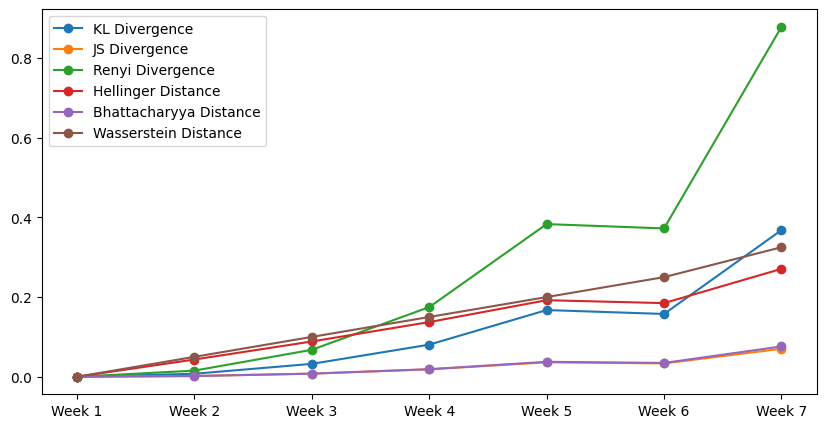

In [6]:
# Kulback-Leibler散度
def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))
# Jensen-Shannon散度
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
# Renyi散度
def renyi_divergence(p, q, alpha=2):
    return (1 / (alpha - 1)) * np.log(np.sum(np.power(p, alpha) * np.power(q, 1 - alpha)))
# Hellinger距离: 两个概率分布的相似度
def hellinger_distance(p, q):
    return np.sqrt(0.5 * np.sum(np.power(np.sqrt(p) - np.sqrt(q), 2)))
# Bhattacharyya距离: 两个概率分布的相似度
def bhattacharyya_distance(p, q):
    return -np.log(np.sum(np.sqrt(p * q)))
# Wasserstein距离: 两个概率分布的相似度(Earth Mover's Distance)
def wasserstein_distance(p, q):
    return np.sum(np.abs(np.cumsum(p) - np.cumsum(q)))

# 计算每周的分布之间的各个指标，并绘制折线图
import matplotlib.pyplot as plt
import numpy as np
weeks = {  
     'Week 1': np.array([0.3, 0.4, 0.2, 0.05, 0.05]),  
     'Week 2': np.array([0.25, 0.45, 0.2, 0.05, 0.05]),  
     'Week 3': np.array([0.2, 0.5, 0.2, 0.05, 0.05]),  
     'Week 4': np.array([0.15, 0.55, 0.2, 0.05, 0.05]),  
     'Week 5': np.array([0.1, 0.6, 0.2, 0.05, 0.05]),  
     'Week 6': np.array([0.1, 0.55, 0.25, 0.05, 0.05]),  
     'Week 7': np.array([0.05, 0.65, 0.25, 0.025, 0.025]),  
 }
kl_divergences, js_divergences, renyi_divergences, hellinger_distances, bhattacharyya_distances, wasserstein_distances = [], [], [], [], [], []
p = weeks['Week 1']
for week, q in weeks.items():
    kl_divergences.append(kl_divergence(p, q))
    js_divergences.append(js_divergence(p, q))
    renyi_divergences.append(renyi_divergence(p, q))
    hellinger_distances.append(hellinger_distance(p, q))
    bhattacharyya_distances.append(bhattacharyya_distance(p, q))
    wasserstein_distances.append(wasserstein_distance(p, q))
plt.figure(figsize=(10, 5))
plt.plot(list(weeks.keys()), kl_divergences, label='KL Divergence', marker='o')
plt.plot(list(weeks.keys()), js_divergences, label='JS Divergence', marker='o')
plt.plot(list(weeks.keys()), renyi_divergences, label='Renyi Divergence', marker='o')
plt.plot(list(weeks.keys()), hellinger_distances, label='Hellinger Distance', marker='o')
plt.plot(list(weeks.keys()), bhattacharyya_distances, label='Bhattacharyya Distance', marker='o')
plt.plot(list(weeks.keys()), wasserstein_distances, label='Wasserstein Distance', marker='o')
plt.legend()
